## 1. Importing Libraries

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import skew

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import (
     train_test_split,
     cross_val_score
)

from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
     FunctionTransformer,
     StandardScaler,
     OneHotEncoder
)

from sklearn.pipeline import (
     Pipeline,
     FeatureUnion
)

from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    make_scorer,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import missingno as msno

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import (
      RandomOverSampler,
      SMOTE,
      SMOTENC
)
from imblearn.ensemble import BalancedRandomForestClassifier

import optuna

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
sklearn.set_config(transform_output = "pandas")

## 2. Reading Data

In [4]:
data = pd.read_csv('../data/payment.csv')
data

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
0,29,1,4.745402,paypal,28.204861,shopping,0.0,0
1,725,1,4.742303,storecredit,0.000000,electronics,0.0,0
2,845,1,4.921318,creditcard,0.000000,food,1.0,0
3,503,1,4.886641,creditcard,0.000000,electronics,1.0,0
4,2000,1,5.040929,creditcard,0.000000,shopping,0.0,0
...,...,...,...,...,...,...,...,...
39216,986,1,4.836982,creditcard,0.000000,shopping,0.0,0
39217,1647,1,4.876771,creditcard,377.930556,shopping,0.0,0
39218,1591,1,4.742303,creditcard,0.000000,shopping,1.0,0
39219,237,1,4.921318,creditcard,236.082639,shopping,1.0,0


In [5]:
data.shape

(39221, 8)

## 3. Preliminary Analysis

### 3.1 Checking for null values

In [8]:
data.isnull().sum()

accountAgeDays            0
numItems                  0
localTime                 0
paymentMethod             0
paymentMethodAgeDays      0
Category                 95
isWeekend               560
label                     0
dtype: int64

- There are null values in the columns `Category` and `isWeekend`

### 3.2 Checking for data types

In [11]:
data.dtypes

accountAgeDays            int64
numItems                  int64
localTime               float64
paymentMethod            object
paymentMethodAgeDays    float64
Category                 object
isWeekend               float64
label                     int64
dtype: object

### 3.3 Checking for duplicate values

In [13]:
data.duplicated().sum()

3033

In [14]:
(
    data
    .loc[data.duplicated(keep = False)]
    .sort_values(by = ['accountAgeDays','numItems','localTime'], ascending = False)
)

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
11678,2000,2,4.962055,creditcard,0.0,shopping,0.0,0
22627,2000,2,4.962055,creditcard,0.0,shopping,0.0,0
5274,2000,2,4.921318,creditcard,0.0,electronics,0.0,0
31285,2000,2,4.921318,creditcard,0.0,electronics,0.0,0
24299,2000,2,4.895263,creditcard,0.0,shopping,0.0,0
...,...,...,...,...,...,...,...,...
18429,1,1,2.596228,paypal,0.0,food,NaN,1
18650,1,1,2.596228,creditcard,0.0,shopping,NaN,1
26246,1,1,2.596228,creditcard,0.0,shopping,NaN,1
31314,1,1,2.596228,creditcard,0.0,shopping,NaN,1


## 4. Detailed Analysis

### 4.1 `accountAgeDays`

In [17]:
data.accountAgeDays

0          29
1         725
2         845
3         503
4        2000
         ... 
39216     986
39217    1647
39218    1591
39219     237
39220     272
Name: accountAgeDays, Length: 39221, dtype: int64

In [18]:
(
    data
    .accountAgeDays
    .describe()
)

count    39221.000000
mean       857.563984
std        804.788212
min          1.000000
25%         72.000000
50%        603.000000
75%       1804.000000
max       2000.000000
Name: accountAgeDays, dtype: float64

### 4.2 `numItems`

In [20]:
data.numItems

0        1
1        1
2        1
3        1
4        1
        ..
39216    1
39217    1
39218    1
39219    1
39220    1
Name: numItems, Length: 39221, dtype: int64

In [21]:
(
    data
    .numItems
    .value_counts()
)

numItems
1     37398
2      1348
5       168
3       164
10       71
4        42
6        15
8         5
7         5
12        1
15        1
29        1
9         1
11        1
Name: count, dtype: int64

### 4.3 `localTime`

In [23]:
data.localTime

0        4.745402
1        4.742303
2        4.921318
3        4.886641
4        5.040929
           ...   
39216    4.836982
39217    4.876771
39218    4.742303
39219    4.921318
39220    5.040929
Name: localTime, Length: 39221, dtype: float64

In [24]:
(
    data
    .localTime
    .describe()
)

count    39221.000000
mean         4.748232
std          0.389360
min          0.421214
25%          4.742303
50%          4.886641
75%          4.962055
max          5.040929
Name: localTime, dtype: float64

### 4.4 `paymentMethod`

In [26]:
data.paymentMethod

0             paypal
1        storecredit
2         creditcard
3         creditcard
4         creditcard
            ...     
39216     creditcard
39217     creditcard
39218     creditcard
39219     creditcard
39220         paypal
Name: paymentMethod, Length: 39221, dtype: object

In [27]:
(
    data
    .paymentMethod
    .value_counts()
)

paymentMethod
creditcard     28004
paypal          9303
storecredit     1914
Name: count, dtype: int64

### 4.5 `paymentMethodAgeDays`

In [29]:
data.paymentMethodAgeDays

0         28.204861
1          0.000000
2          0.000000
3          0.000000
4          0.000000
            ...    
39216      0.000000
39217    377.930556
39218      0.000000
39219    236.082639
39220      0.000694
Name: paymentMethodAgeDays, Length: 39221, dtype: float64

In [30]:
(
    data
    .paymentMethodAgeDays
    .describe()
)

count    39221.000000
mean       122.641326
std        283.569177
min          0.000000
25%          0.000000
50%          0.012500
75%         87.510417
max       1999.580556
Name: paymentMethodAgeDays, dtype: float64

In [31]:
(
    data
    .sort_values(by = 'paymentMethodAgeDays')
)

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
11590,897,1,4.965339,paypal,0.000000,food,1.0,0
9698,84,1,4.921349,creditcard,0.000000,food,0.0,0
32542,2000,1,4.742303,creditcard,0.000000,shopping,1.0,0
32536,6,1,4.876771,creditcard,0.000000,shopping,1.0,0
27064,21,1,4.742303,creditcard,0.000000,food,0.0,0
...,...,...,...,...,...,...,...,...
10956,2000,1,4.886641,creditcard,1988.692361,shopping,1.0,0
16357,2000,1,4.886641,creditcard,1988.699306,food,1.0,0
8540,2000,1,4.965339,creditcard,1991.989583,electronics,1.0,0
4370,2000,1,4.461622,creditcard,1994.804861,shopping,1.0,0


- `paymentMethodAgeDays` should be converted to int

### 4.6 `Category`

In [34]:
data.Category

0           shopping
1        electronics
2               food
3        electronics
4           shopping
            ...     
39216       shopping
39217       shopping
39218       shopping
39219       shopping
39220       shopping
Name: Category, Length: 39221, dtype: object

In [35]:
(
    data
    .Category
    .value_counts()
)

Category
shopping       13328
food           12964
electronics    12834
Name: count, dtype: int64

### 4.7 `isWeekend`

In [37]:
data.isWeekend

0        0.0
1        0.0
2        1.0
3        1.0
4        0.0
        ... 
39216    0.0
39217    0.0
39218    1.0
39219    1.0
39220    0.0
Name: isWeekend, Length: 39221, dtype: float64

In [38]:
(
    data
    .isWeekend
    .value_counts()
)

isWeekend
0.0    19348
1.0    19313
Name: count, dtype: int64

### 4.8 `label`

In [40]:
data.label

0        0
1        0
2        0
3        0
4        0
        ..
39216    0
39217    0
39218    0
39219    0
39220    0
Name: label, Length: 39221, dtype: int64

In [41]:
(
    data
    .label
    .value_counts()
)

label
0    38661
1      560
Name: count, dtype: int64

## 5. Cleaning Operations

In [43]:
data_cleaned = (
    data
    .rename(columns = str.lower)  # fixing column names
    .rename(columns = {
        'accountagedays': 'account_age',
        'numitems': 'num_items',
        'localtime': 'local_time',
        'paymentmethod': 'payment_method',
        'paymentmethodagedays':'method_age',
        'isweekend': 'is_weekend'
    })
    .assign(
        method_age = lambda df: np.floor(df.method_age).astype('int') # method age days converted to int
    )
    .drop_duplicates() # dropping duplcates
)

In [44]:
data_cleaned

,account_age,num_items,local_time,payment_method,method_age,category,is_weekend,label
0,29,1,4.745402,paypal,28,shopping,0.0,0
1,725,1,4.742303,storecredit,0,electronics,0.0,0
2,845,1,4.921318,creditcard,0,food,1.0,0
3,503,1,4.886641,creditcard,0,electronics,1.0,0
4,2000,1,5.040929,creditcard,0,shopping,0.0,0
...,...,...,...,...,...,...,...,...
39216,986,1,4.836982,creditcard,0,shopping,0.0,0
39217,1647,1,4.876771,creditcard,377,shopping,0.0,0
39218,1591,1,4.742303,creditcard,0,shopping,1.0,0
39219,237,1,4.921318,creditcard,236,shopping,1.0,0


## 6. Train Test Split

In [46]:
X = data_cleaned.drop(columns = 'label')
y = data_cleaned.label.copy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 42)

train = X_train.join(y_train)
test = X_test.join(y_test)

In [47]:
print(f'The shapes of train and test datasets are {train.shape} and {test.shape} respectively')

The shapes of train and test datasets are (22862, 8) and (9798, 8) respectively


## 7. Exploratory Data Analysis

### 7.1 Higher Level Distribution Analysis

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22862 entries, 17568 to 27692
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   account_age     22862 non-null  int64  
 1   num_items       22862 non-null  int64  
 2   local_time      22862 non-null  float64
 3   payment_method  22862 non-null  object 
 4   method_age      22862 non-null  int32  
 5   category        22803 non-null  object 
 6   is_weekend      22708 non-null  float64
 7   label           22862 non-null  int64  
dtypes: float64(2), int32(1), int64(3), object(2)
memory usage: 2.0+ MB


In [51]:
train.describe(include = 'number')

,account_age,num_items,local_time,method_age,is_weekend,label
count,22862.000000,22862.000000,22862.000000,22862.000000,22708.000000,22862.000000
mean,791.676975,1.099729,4.742468,144.721284,0.498327,0.006736
std,752.715211,0.592468,0.401096,303.880670,0.500008,0.081798
min,1.000000,1.000000,0.421214,0.000000,0.000000,0.000000
25%,89.000000,1.000000,4.742303,0.000000,0.000000,0.000000
50%,545.000000,1.000000,4.886641,0.000000,0.000000,0.000000
75%,1551.750000,1.000000,4.962055,131.000000,1.000000,0.000000
max,2000.000000,15.000000,5.040929,1999.000000,1.000000,1.000000


In [52]:
train.describe(include = 'O')

,payment_method,category
count,22862,22803
unique,3,3
top,creditcard,shopping
freq,15868,7690


In [53]:
(
    train
    .label
    .value_counts()
)

label
0    22708
1      154
Name: count, dtype: int64

In [54]:
## EDA Helper Functions

def show_pie_chart(data,col):
        counts = data[col].value_counts()
        
        plt.pie(
            counts,
            labels = counts.index,
            autopct = '%2.2f%%',
            pctdistance = 1.8,
        )
        
        plt.title(f'{col} Distribution')
        plt.show()
    
def missing_info(data):
  na_cols = [col for col in data.columns if data[col].isna().any()]
  na_counts = [data[col].isna().sum() for col in na_cols]
  na_pct = [(data[col].isna().mean() * 100) for col in na_cols]

  return (
      pd
      .DataFrame(data={
          "variable": na_cols,
          "count": na_counts,
          "percentage": na_pct
      })
      .sort_values(by="count", ascending=False)
      .set_index("variable")
  )

def num_describe(data,col,percentiles = [0.1,0.3,0.5,0.7,0.9],percentiles_add = []):

    if percentiles_add!= []:
       percentiles = percentiles + percentiles_add
    return pd.DataFrame(
        data[col]
        .describe(
            percentiles = percentiles
        )
    )
    

def num_univar_plots(data,col):
    
    fig,ax = plt.subplots(1,2,figsize = (15,5))

    sns.distplot(kde = True,ax = ax[0],x = data[col])
    ax[0].set_title(f'{col} distplot')
    ax[0].set_xlabel(f'{col}')
    
    sns.boxplot(data = data, y = col)
    ax[1].set_title(f'{col} boxplot')
    
    plt.show() 

    print("\n\n")
    print(f"Skewness of {col}: {data[col].skew()}")


def num_cat_bivar_plots(data,num_var,cat_var):

    print("\n\n")

    fig,ax = plt.subplots(1,2,figsize = (15,5))
    
    sns.barplot( data = data, x = cat_var, y = num_var,estimator = "median",ax = ax[0])
    ax[0].set_title(f'{cat_var} median {num_var} distribution')

    sns.barplot( data = data, x = cat_var, y = num_var,estimator = "mean",ax = ax[1])
    ax[1].set_title(f'{cat_var} mean {num_var} distribution')
        
    print(f"Median and Mean {num_var} Distribution per category:")

    median_df = train.groupby(cat_var)[num_var].median().reset_index().set_index(cat_var)
    mean_df = train.groupby(cat_var)[num_var].mean().reset_index().set_index(cat_var)

    return median_df.merge(mean_df,on = cat_var).rename(columns = {f'{num_var}_x':f'{num_var}_median', f'{num_var}_y':f'{num_var}_mean'})

def cat_heatmap(data,x_var,y_var):

    fig = plt.figure(figsize=(15,5))
    gs = fig.add_gridspec(2,2)
    
    ax0 = fig.add_subplot(gs[0,:])
    
    sns.heatmap(pd.crosstab(train[f"{y_var}"], train[f"{x_var}"],normalize = "columns")*100,annot = True,ax = ax0)
    ax0.set_title(f'Crosstab Heatmap for {y_var} and {x_var} normalized to columns')

    ax1 = fig.add_subplot(gs[1,:])
    
    sns.heatmap(pd.crosstab(train[f"{y_var}"], train[f"{x_var}"],normalize = "index")*100,annot = True,ax = ax1)
    ax1.set_title(f'Crosstab Heatmap for {y_var} and {x_var} normalized to rows')

    plt.tight_layout()
    
    plt.show()


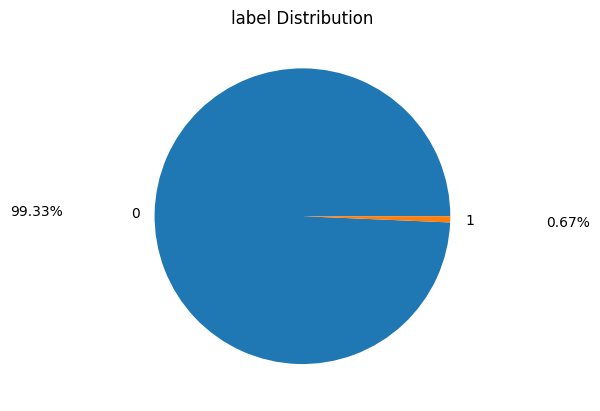

In [55]:
show_pie_chart(train,"label")

- The target column has heavy class imbalance

### 7.2 `Higher Level Missing Value Analysis`

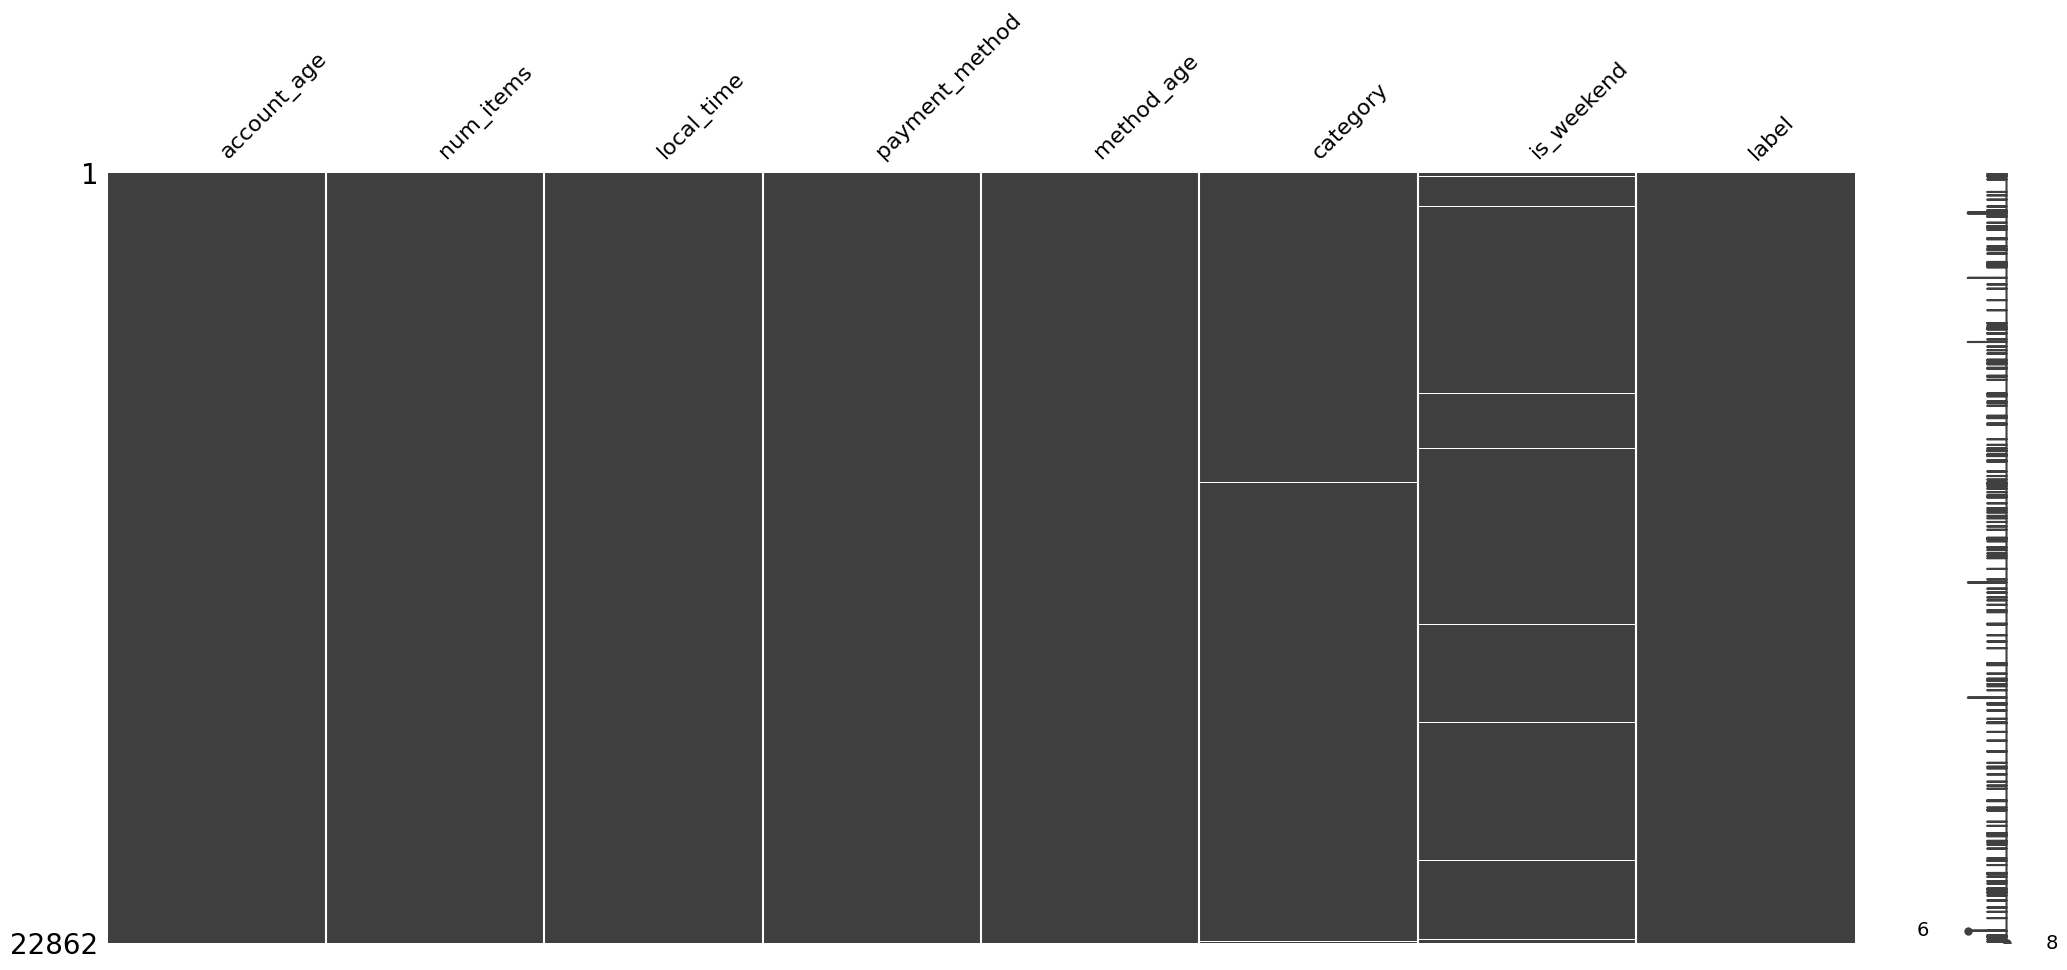

In [58]:
msno.matrix(train)

plt.show()

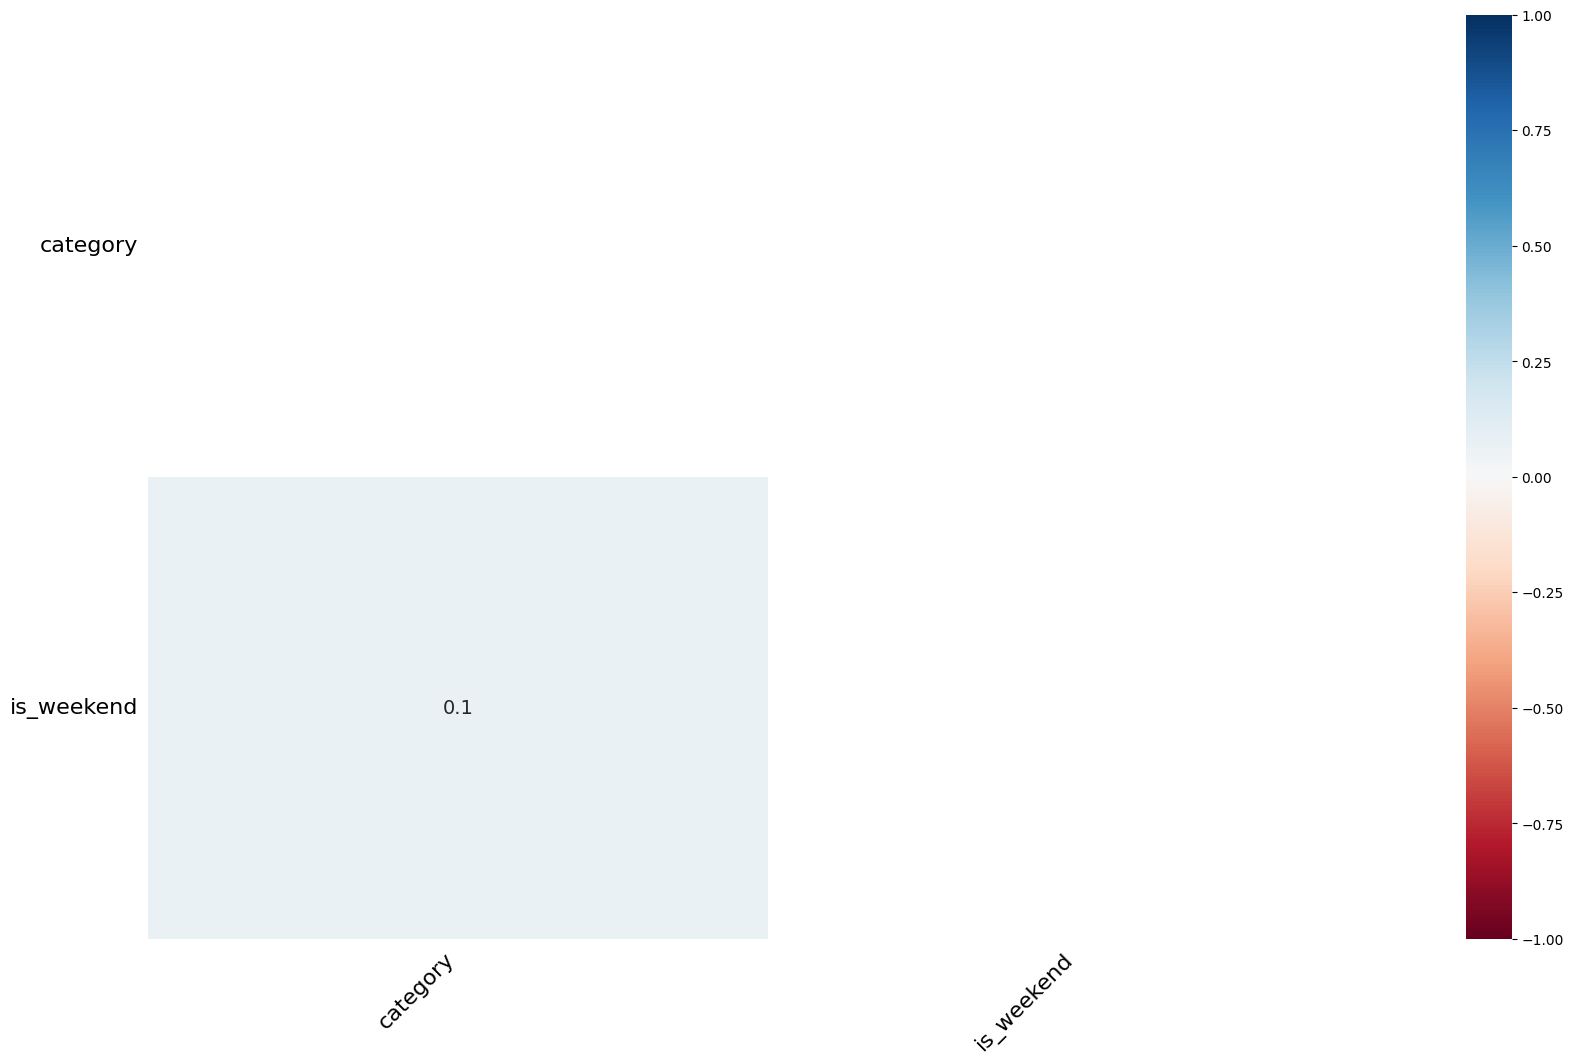

In [59]:
msno.heatmap(train)
plt.show()

- the missing values of both `category` and `is_weekend` does not have any correlation

In [61]:
missing_info(train)

,count,percentage
variable,,
is_weekend,154,0.673607
category,59,0.258070


### 7.3 `Detailed Analysis`

#### 7.3.1 `account_age`

In [64]:
train.account_age

17568      57
21032      39
25091     519
27640     477
5793      149
         ... 
35552    2000
5828     1001
873        85
18022       8
27692      82
Name: account_age, Length: 22862, dtype: int64

In [65]:
num_describe(train,"account_age",percentiles_add = [0.05,0.01])

,account_age
count,22862.000000
mean,791.676975
std,752.715211
min,1.000000
1%,2.000000
5%,5.000000
10%,15.000000
30%,127.000000
50%,545.000000
70%,1288.000000


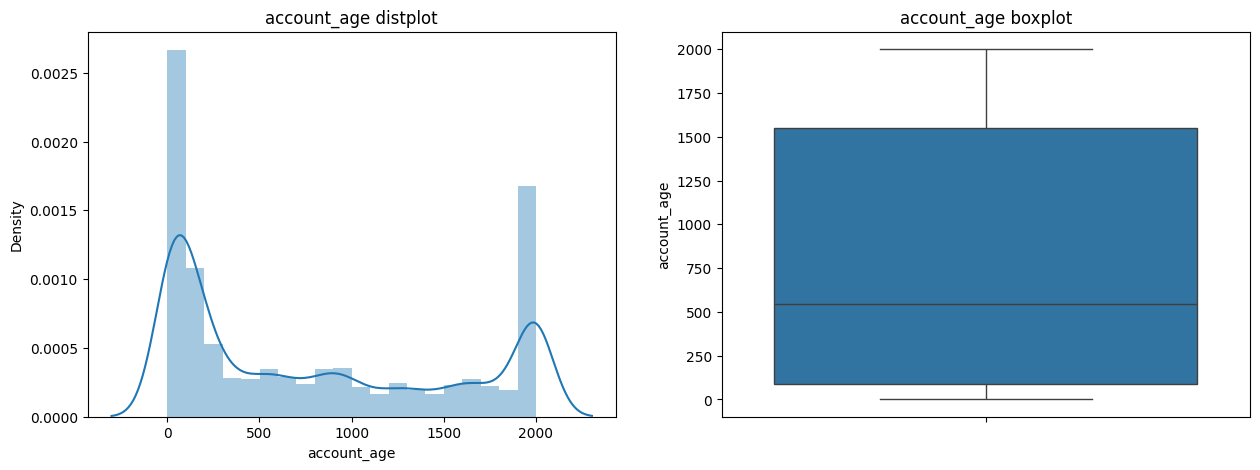




Skewness of account_age: 0.500199011312291


In [66]:
num_univar_plots(train,"account_age")




Median and Mean account_age Distribution per category:


,account_age_median,account_age_mean
label,,
0,552.5,797.039149
1,1.0,1.000000


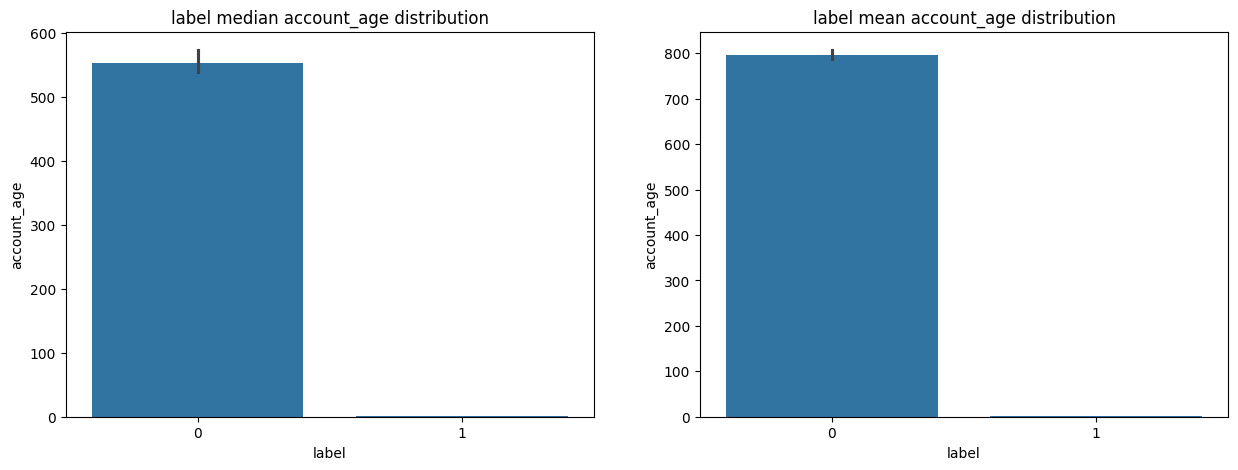

In [67]:
num_cat_bivar_plots(train,"account_age","label")

In [68]:
(
    train
    .loc[lambda df: df.label.eq(1)]
)

,account_age,num_items,local_time,payment_method,method_age,category,is_weekend,label
18808,1,3,4.745402,creditcard,0,food,NaN,1
24329,1,10,5.040929,paypal,0,shopping,NaN,1
1358,1,1,3.575983,creditcard,0,shopping,NaN,1
19042,1,2,4.876771,creditcard,0,food,NaN,1
3409,1,1,4.836982,creditcard,0,shopping,NaN,1
...,...,...,...,...,...,...,...,...
7232,1,1,3.954522,paypal,0,electronics,NaN,1
37444,1,1,5.034622,storecredit,0,food,NaN,1
7558,1,2,4.745402,creditcard,0,electronics,NaN,1
36527,1,2,5.017904,creditcard,0,electronics,NaN,1


In [69]:
(
    train
    .loc[lambda df: df.label.eq(1)]
    .pipe(num_describe,"account_age")
)

,account_age
count,154.0
mean,1.0
std,0.0
min,1.0
10%,1.0
30%,1.0
50%,1.0
70%,1.0
90%,1.0
max,1.0


In [70]:
(
    train
    .loc[lambda df: df.account_age.eq(1)]
    .pipe(num_describe,"label")
)

,label
count,154.0
mean,1.0
std,0.0
min,1.0
10%,1.0
30%,1.0
50%,1.0
70%,1.0
90%,1.0
max,1.0


In [71]:
(
    train
    .loc[lambda df: df.label.eq(1)]
    .method_age.value_counts()
)

method_age
0    154
Name: count, dtype: int64

- All the fraud transactions have `account_age` of 1
- All the non-fraud transactions have `account_age` not equal to 1
- This looks like a biased column and does not generalise the true nature of population

#### 7.3.2 `num_items`

In [74]:
train.num_items

17568    1
21032    1
25091    5
27640    1
5793     1
        ..
35552    1
5828     1
873      1
18022    1
27692    1
Name: num_items, Length: 22862, dtype: int64

In [75]:
num_describe(train,"num_items")

,num_items
count,22862.000000
mean,1.099729
std,0.592468
min,1.000000
10%,1.000000
30%,1.000000
50%,1.000000
70%,1.000000
90%,1.000000
max,15.000000


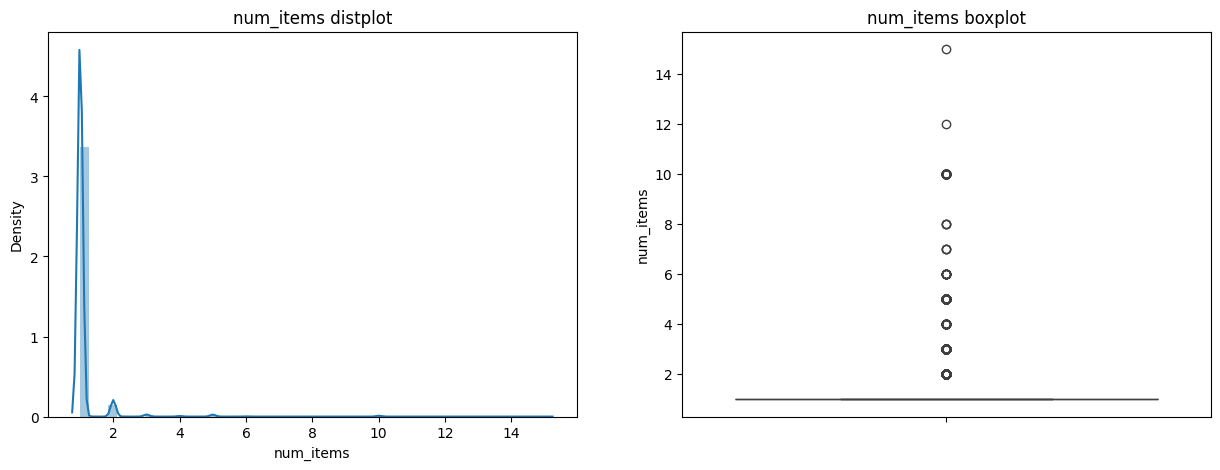




Skewness of num_items: 10.452967106825012


In [76]:
num_univar_plots(train,"num_items")

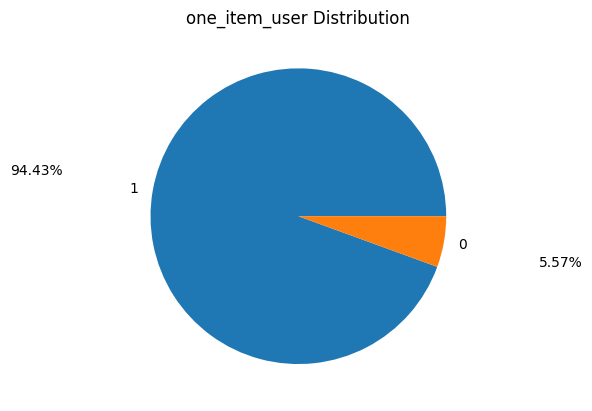

In [77]:
temp_df = (
    train
    .assign(
        one_item_user = lambda df: (
            np.where(
                df.num_items.eq(1),
                1,
                0
            )
        )
    )
)

show_pie_chart(temp_df,"one_item_user")

- the data is heavily right skewed
- most of the values are equal to 1




Median and Mean num_items Distribution per category:


,num_items_median,num_items_mean
label,,
0,1.0,1.096354
1,1.0,1.597403


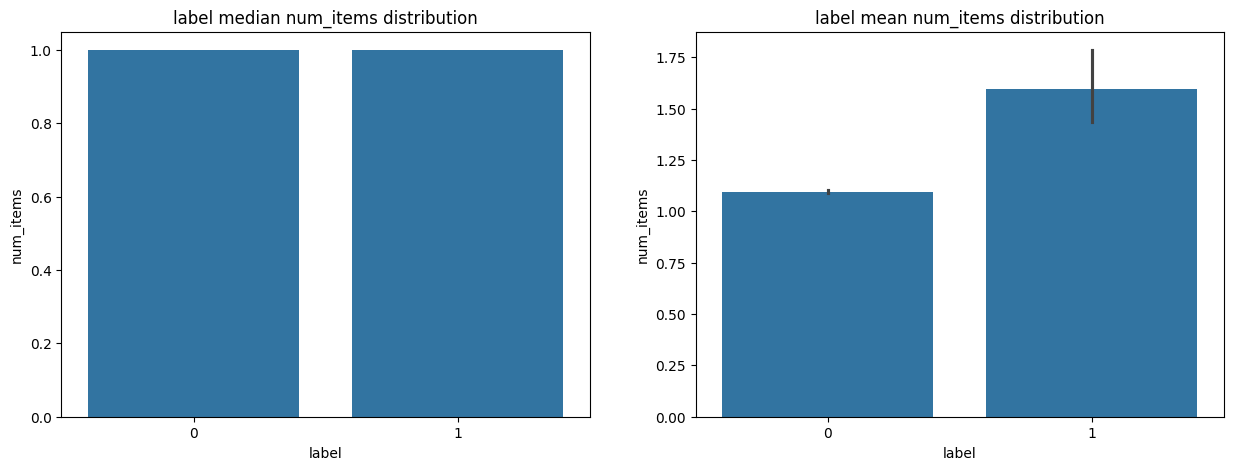

In [79]:
num_cat_bivar_plots(train,"num_items","label")

#### 7.3.3 `local_time`

In [81]:
train.local_time

17568    4.965339
21032    4.524580
25091    3.066058
27640    4.876771
5793     4.876771
           ...   
35552    4.921318
5828     4.524580
873      4.921349
18022    5.040929
27692    4.748314
Name: local_time, Length: 22862, dtype: float64

In [82]:
num_describe(train, "local_time")

,local_time
count,22862.000000
mean,4.742468
std,0.401096
min,0.421214
10%,4.461622
30%,4.745402
50%,4.886641
70%,4.921349
90%,5.034622
max,5.040929


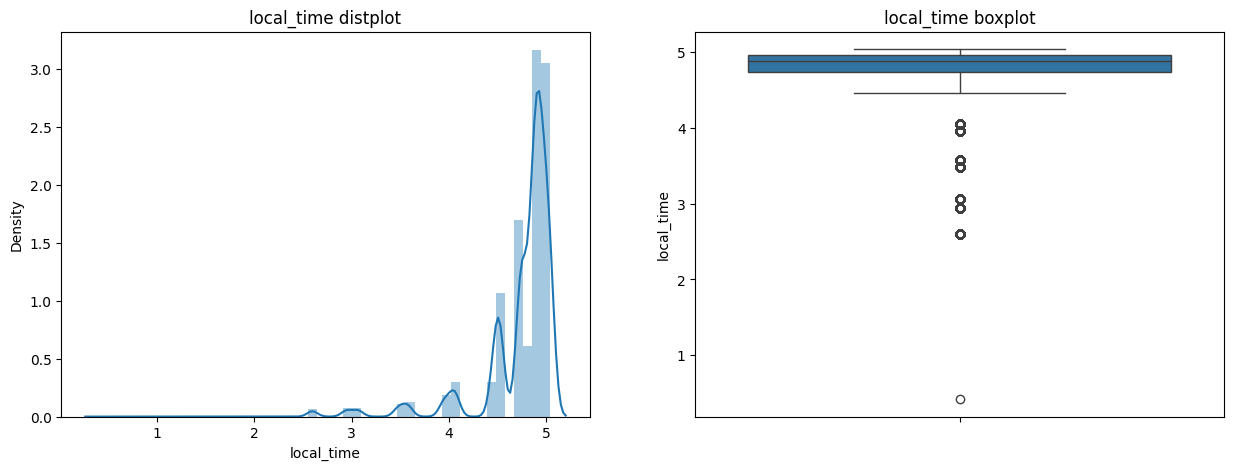




Skewness of local_time: -2.9149660859520257


In [83]:
num_univar_plots(train,"local_time")

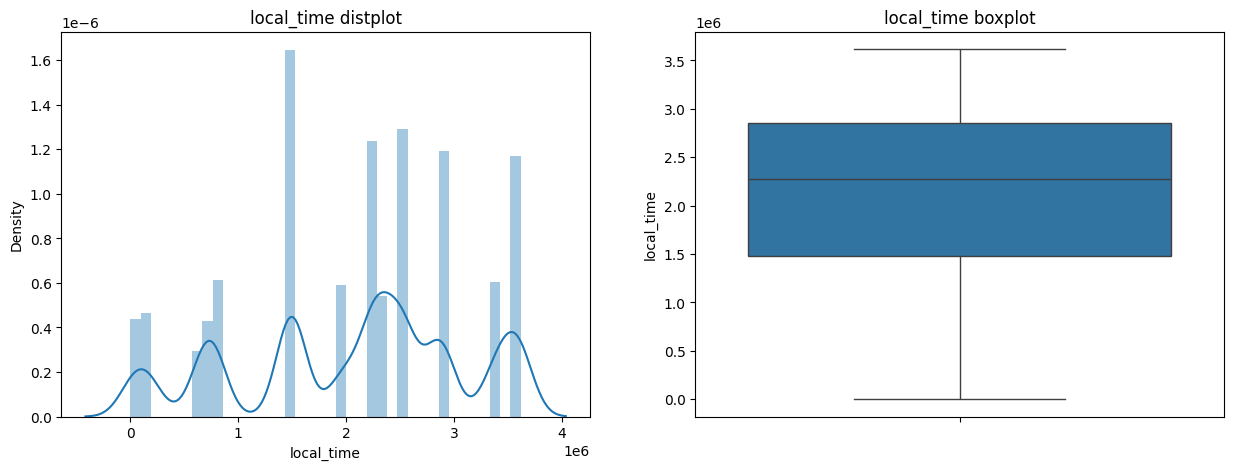




Skewness of local_time: -0.34053588509241167


In [84]:
train_temp = train.assign(local_time = 20**train.local_time)

num_univar_plots(train_temp,"local_time")

- the data is left skewed




Median and Mean local_time Distribution per category:


,local_time_median,local_time_mean
label,,
0,4.886641,4.744188
1,4.748314,4.488817


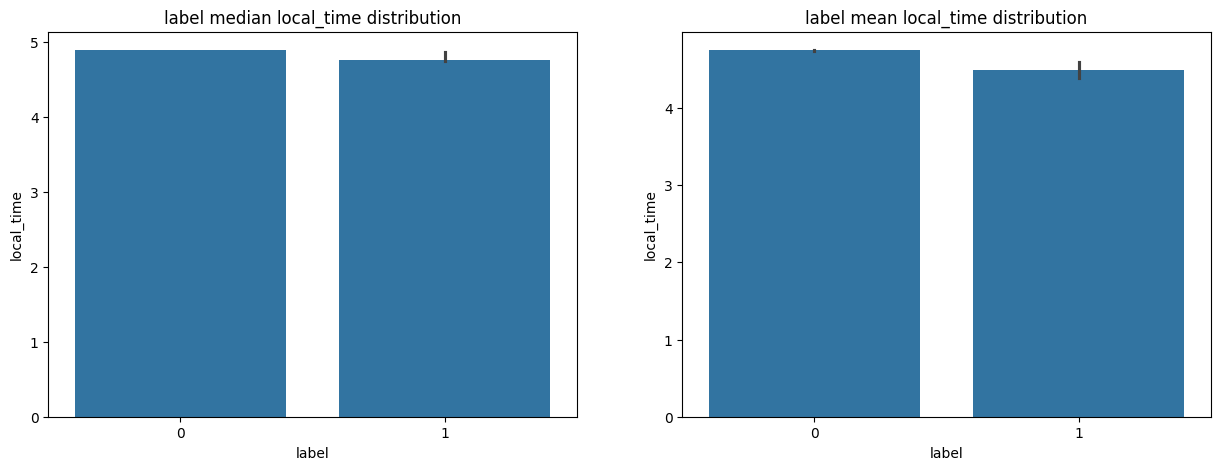

In [86]:
num_cat_bivar_plots(train,"local_time","label")

#### 7.3.4 `method_age`

In [88]:
train.method_age

17568     28
21032     38
25091    518
27640      0
5793     148
        ... 
35552    156
5828      10
873        0
18022      0
27692      0
Name: method_age, Length: 22862, dtype: int32

In [89]:
num_describe(train, "method_age")

,method_age
count,22862.000000
mean,144.721284
std,303.880670
min,0.000000
10%,0.000000
30%,0.000000
50%,0.000000
70%,83.000000
90%,514.000000
max,1999.000000


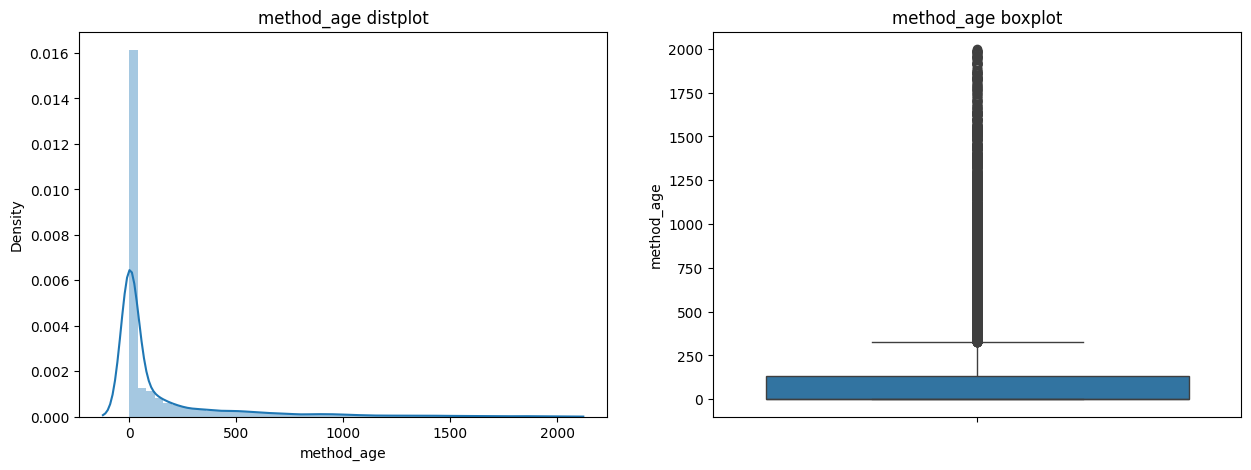




Skewness of method_age: 2.940837155131137


In [90]:
num_univar_plots(train,"method_age")

- data is heavily right skewed




Median and Mean method_age Distribution per category:


,method_age_median,method_age_mean
label,,
0,0.0,145.702748
1,0.0,0.000000


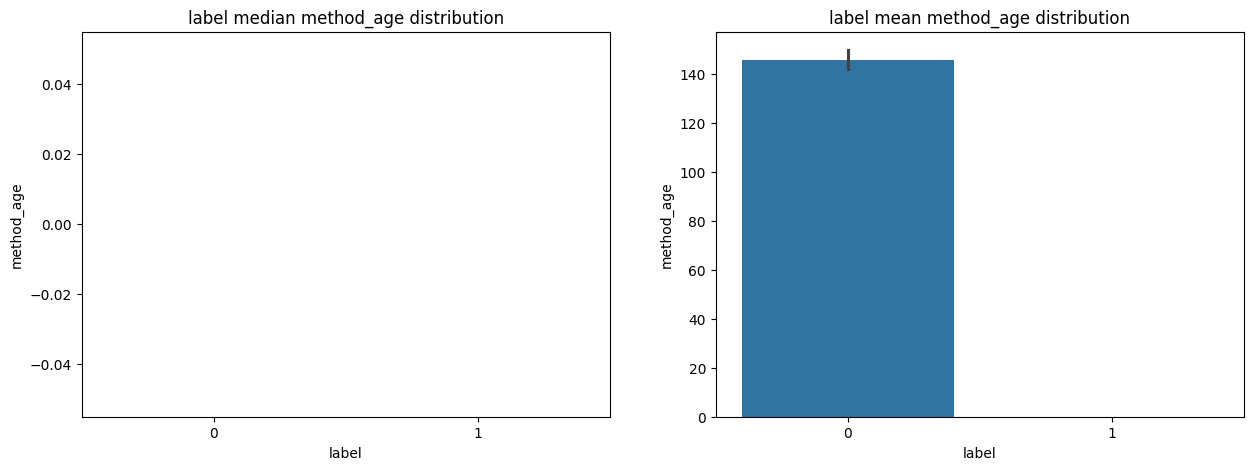

In [92]:
num_cat_bivar_plots(train,"method_age","label")

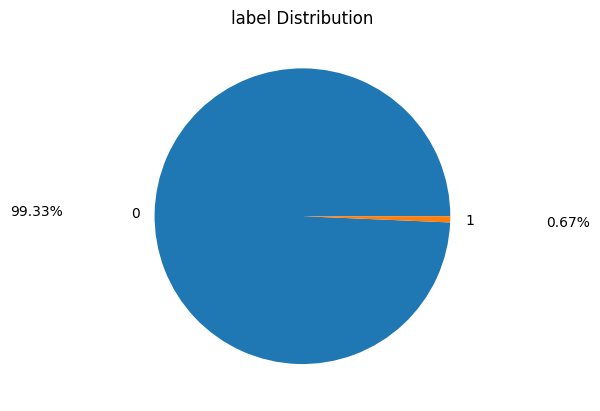

In [93]:
temp_df = (
    train
    .loc[lambda df: df.method_age.eq(0)]
)

show_pie_chart(train,"label")

- all fraud transactions have `method_age` equal to 0 but not all 0 `method_age` are fraudulent
- transactions with `method_age` equal to 0 (fresh payment methods) have strong chance of being fraudulent

### 7.3.5 `payment_method`

In [96]:
train.payment_method

17568    creditcard
21032        paypal
25091        paypal
27640    creditcard
5793     creditcard
            ...    
35552        paypal
5828     creditcard
873      creditcard
18022        paypal
27692    creditcard
Name: payment_method, Length: 22862, dtype: object

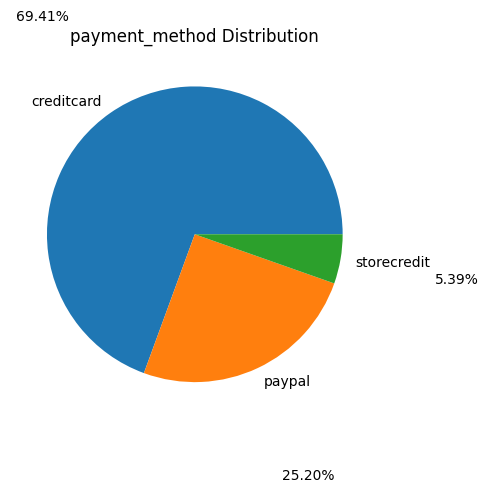

In [97]:
show_pie_chart(train,"payment_method")

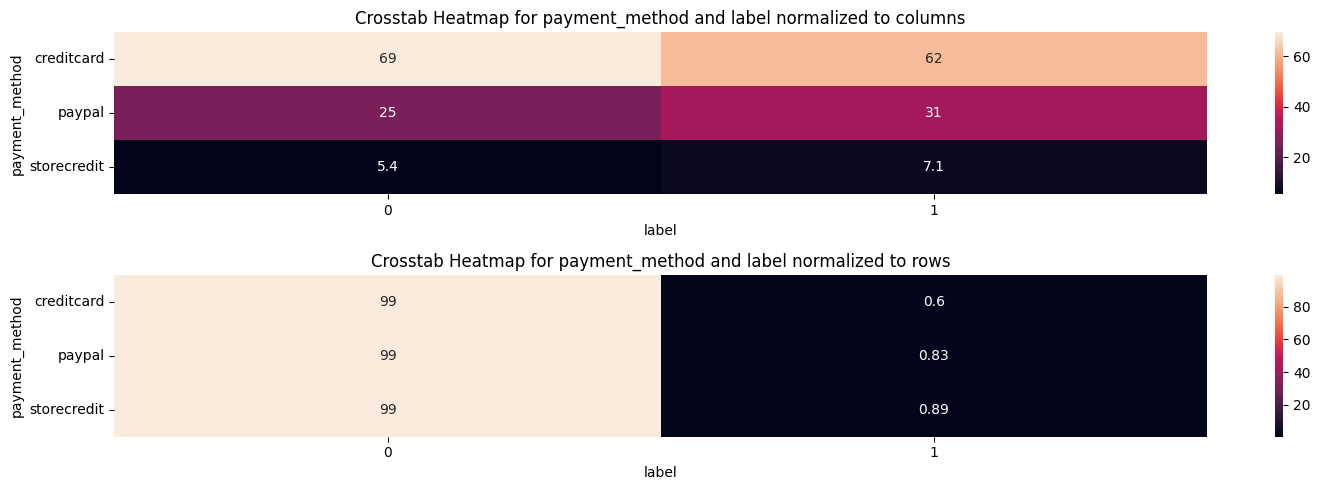

In [98]:
cat_heatmap(train,"label","payment_method")

- paypal and storecredit are rarer payment methods than creditcard but have higher number of fraudulent activities than creditcard

### 7.3.6 `is_weekend`

In [101]:
train.is_weekend

17568    0.0
21032    1.0
25091    1.0
27640    0.0
5793     1.0
        ... 
35552    1.0
5828     0.0
873      0.0
18022    1.0
27692    1.0
Name: is_weekend, Length: 22862, dtype: float64

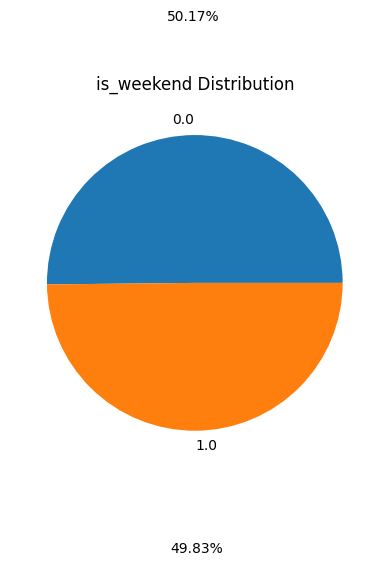

In [102]:
show_pie_chart(train,"is_weekend")

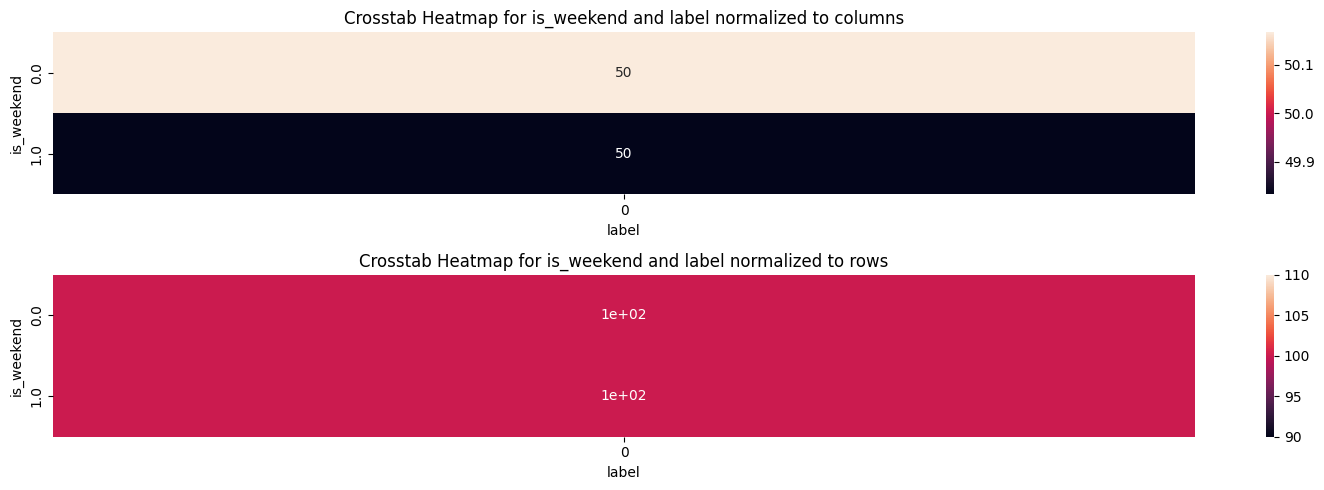

In [103]:
cat_heatmap(train,"label","is_weekend")

In [104]:
train.loc[train.is_weekend.eq(0)].label.value_counts()

label
0    11392
Name: count, dtype: int64

In [105]:
train.loc[train.is_weekend.eq(1)].label.value_counts()

label
0    11316
Name: count, dtype: int64

- This column says fraud is not happening when is_weekend info is given
- Might be coincidental and not represent true nature of population

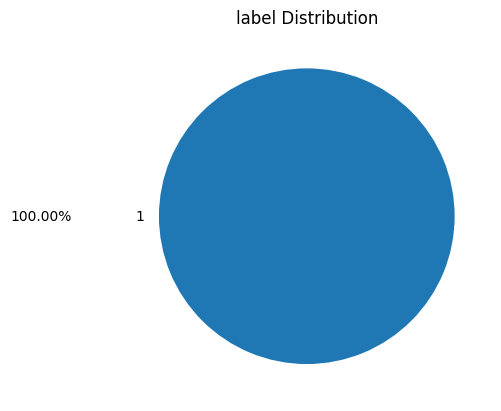

In [107]:
show_pie_chart(train.loc[train.is_weekend.isna()],"label")

- The rows where is_weekend is missing all rows are fraudulent

### 7.3.7 `category`

In [110]:
train.category

17568       shopping
21032           food
25091    electronics
27640           food
5793        shopping
            ...     
35552    electronics
5828     electronics
873      electronics
18022       shopping
27692    electronics
Name: category, Length: 22862, dtype: object

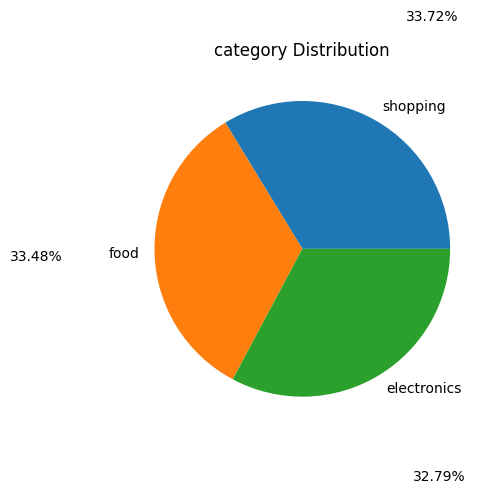

In [111]:
show_pie_chart(train,"category")

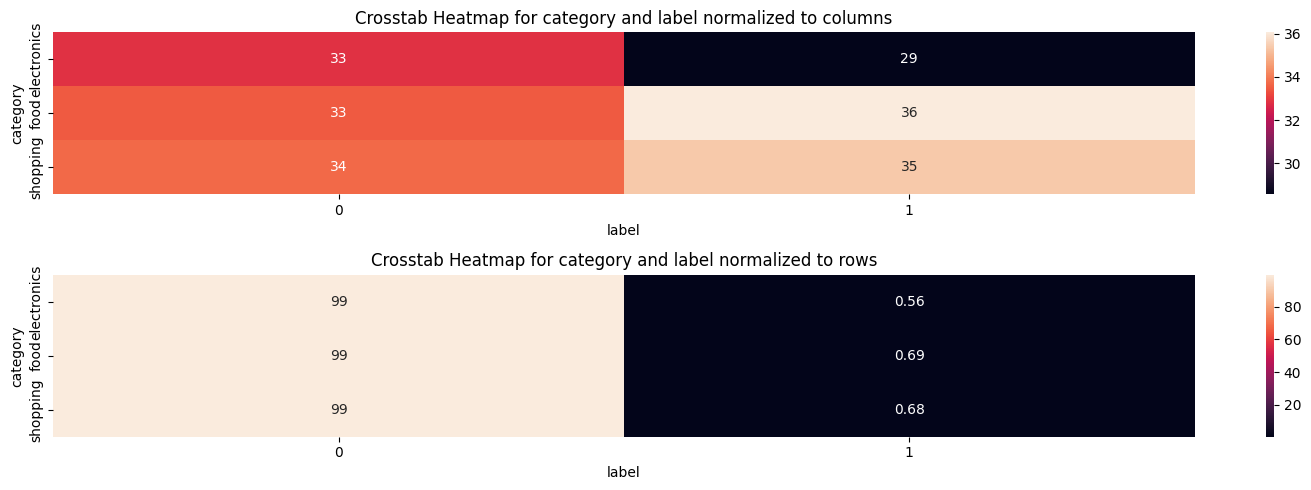

In [112]:
cat_heatmap(train,"label","category")

- shopping category has higher chance of fraudulent payments compared to others

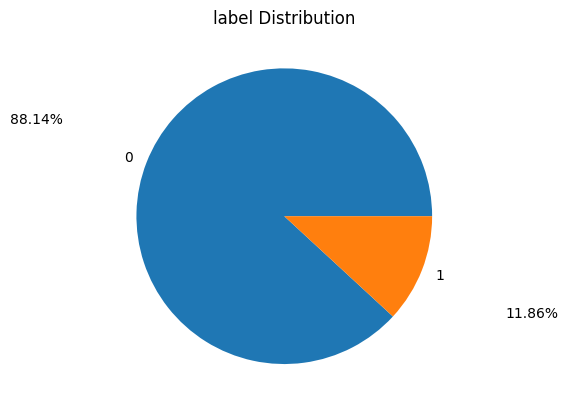

In [114]:
show_pie_chart(train.loc[train.category.isna()],"label")

## 8. Feature Engineering

In [116]:
X_train =  train.drop(columns = "label")
y_train = train.label.copy()

### 8.1 Column Transformation

#### 8.1.1 `num_items`

In [119]:
def one_time_user(X):
    
    columns = X.columns.to_list()

    return(
        X
        .assign(
            one_time_user = np.where(
                X.num_items.eq(1),1,0
            )
        )
        .drop(columns = columns)
    )

In [120]:
num_items_pipe1 = Pipeline(steps = [
    ("scaler",StandardScaler())
])

num_items_pipe2 = Pipeline(steps = [
    ("binner",FunctionTransformer(func = one_time_user))
])

num_items_transformer = FeatureUnion(transformer_list = [
    ("num_items_pipe1",num_items_pipe1),
    ("num_items_pipe2",num_items_pipe2)
])

#### 8.1.2 `local_item`

In [122]:
local_time_transformer = Pipeline(steps = [
    ("exp",FunctionTransformer(func = lambda x: 20**x)),
    ("scaler",StandardScaler())
])

#### 8.1.3 `payment_method`

In [124]:
payment_method_transformer = Pipeline(steps = [
    ("binner",FunctionTransformer(func = lambda x:np.where(x.eq('creditcard'),1,0)))
])

#### 8.1.4 `method_age`

In [126]:
method_age_pipe1 = Pipeline(steps = [
    ("cbrt",FunctionTransformer(func = lambda x: np.cbrt(x))),
    ("scaler",StandardScaler())
])

method_age_pipe2 = Pipeline(steps = [
    ("binner",FunctionTransformer(func = lambda x:np.where(x.eq(0),1,0)))
])

method_age_transformer = FeatureUnion(transformer_list = [
    ("method_age_pipe1",method_age_pipe1),
    ("method_age_pipe2",method_age_pipe2)
])

### 8.1.5 `category`

In [128]:
category_transformer =  Pipeline(steps = [
    ("imputer",SimpleImputer(strategy = 'constant',fill_value = 'shopping')),
    ("encoder",OneHotEncoder(drop = 'first',sparse_output = False,handle_unknown = 'ignore'))
])

### 8.1.6 `is_weekend`

In [130]:
is_weekend_transformer = Pipeline(steps = [
    ("imputer", FunctionTransformer(func = lambda x: np.where(x.isna(),np.random.choice([0,1]),x)))
])

#### 8.1.7 `account_age`

In [361]:
account_age_transformer = Pipeline(steps = [
    ("binner",FunctionTransformer(func = lambda x: np.where(x.le(2),1,0)))
])

In [365]:
feature_transformer = ColumnTransformer(transformers = [
    ("account_age_transformer",account_age_transformer,["account_age"]),
    ("num_items_transformer",num_items_transformer,["num_items"]),
    ("local_time_transformer",local_time_transformer,["local_time"]),
    ("payment_method_transformer",payment_method_transformer,["payment_method"]),
    ("method_age_transfomer",method_age_transformer,["method_age"]),
    ("category_transformer",category_transformer,["category"]),
    ("is_weekend_transformer",is_weekend_transformer,["is_weekend"])
])

feature_transformer.fit_transform(X_train,y_train)

,0,1,2,3,4,5,6,7,8,9
17568,0.0,-0.168332,1.0,0.796235,1.0,0.116504,0.0,0.0,1.0,0.0
21032,0.0,-0.168332,1.0,-1.243671,0.0,0.213570,0.0,1.0,0.0,1.0
25091,0.0,6.583241,0.0,-1.977425,0.0,1.606424,0.0,0.0,0.0,1.0
27640,0.0,-0.168332,1.0,0.147657,1.0,-0.789339,1.0,1.0,0.0,0.0
5793,0.0,-0.168332,1.0,0.147657,1.0,0.788591,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
35552,0.0,-0.168332,1.0,0.452388,0.0,0.816525,0.0,0.0,0.0,1.0
5828,0.0,-0.168332,1.0,-1.243671,1.0,-0.146651,0.0,0.0,0.0,0.0
873,0.0,-0.168332,1.0,0.452615,1.0,-0.789339,1.0,0.0,0.0,0.0
18022,0.0,-0.168332,1.0,1.503514,0.0,-0.789339,1.0,0.0,1.0,1.0


### 8.2 Class Imbalance Treatment

In [367]:
class_imbalance_resampler = SMOTE(k_neighbors = 100,random_state = 42)

In [369]:
feature_engineer = ImbPipeline(steps = [
    ("feature_transformer",feature_transformer),
    ("class_imbalance_resampler",class_imbalance_resampler)
])

feature_engineer.fit_resample(X_train,y_train)

(         0         1         2         3         4         5    6         7  \
 0      0.0 -0.168332  1.000000  0.796235  1.000000  0.116504  0.0  0.000000   
 1      0.0 -0.168332  1.000000 -1.243671  0.000000  0.213570  0.0  1.000000   
 2      0.0  6.583241  0.000000 -1.977425  0.000000  1.606424  0.0  0.000000   
 3      0.0 -0.168332  1.000000  0.147657  1.000000 -0.789339  1.0  1.000000   
 4      0.0 -0.168332  1.000000  0.147657  1.000000  0.788591  0.0  0.000000   
 ...    ...       ...       ...       ...       ...       ...  ...       ...   
 45411  1.0 -0.168332  1.000000  0.452388  0.365666 -0.789339  1.0  0.365666   
 45412  1.0  0.142801  0.815668 -1.413634  0.184332 -0.789339  1.0  1.000000   
 45413  1.0  0.312468  0.715148 -1.644018  0.284852 -0.789339  1.0  1.000000   
 45414  1.0  1.519561  0.000000 -1.946936  1.000000 -0.789339  1.0  0.000000   
 45415  1.0  3.966594  0.183415 -0.092190  1.000000 -0.789339  1.0  0.000000   
 
               8    9  
 0      1.0000

## 9. Model Training

In [371]:
X_test = test.drop(columns = "label")
y_test = test.label.copy()

In [373]:
model_training_pipeline = ImbPipeline(steps = [
    ("feature_transformer",feature_transformer),
    ("class_imbalance_resampler",class_imbalance_resampler),
    ("model",RandomForestClassifier(class_weight = 'balanced'))
])

model_training_pipeline.set_output(transform="pandas")

Pipeline(steps=[('feature_transformer',
                 ColumnTransformer(transformers=[('account_age_transformer',
                                                  Pipeline(steps=[('binner',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001763809A0C0>))]),
                                                  ['account_age']),
                                                 ('num_items_transformer',
                                                  FeatureUnion(transformer_list=[('num_items_pipe1',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())])),
                                                                                 ('num_items_pipe2',...
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['category']),
                                                 ('is_weekend_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001763804BE20>))]),
                                                  ['is_weekend'])])),
                ('class_imbalance_resampler',
                 SMOTE(k_neighbors=100, random_state=42)),
                ('model', RandomForestClassifier(class_weight='balanced'))])

In [375]:
def objective(trial):

    # tuning the hyperparameters
    n_estimators = trial.suggest_int('n_estimators',10,500)
    max_depth = trial.suggest_int('max_depth',2,50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    class_weight = trial.suggest_categorical('class_weight',[None,'balanced','balanced_subsample'])

    # model 
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight = class_weight,
        random_state = 42,
        n_jobs = -1
    )
    
    model_training_pipeline = ImbPipeline(steps = [
    ("feature_transformer",feature_transformer),
    ("class_imbalance_resampler",class_imbalance_resampler),
    ("model",model)
    ])

    # recall scorer for class 1
    recall_scorer = make_scorer(recall_score,pos_label = 1)

    # cross validation score
    train_recall_score = cross_val_score(
        estimator = model_training_pipeline,
        X = X_train,
        y = y_train,
        cv=3,
        scoring = recall_scorer,
        n_jobs = -1
    )

    # test_f1_score = cross_val_score(
    #     estimator = model_training_pipeline,
    #     X = X_test,
    #     y = y_test,
    #     cv = 3,
    #     scoring = f1_scorer,
    #     n_jobs = -1
    # )

    score = train_recall_score 
    
    return score.mean()

In [377]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective,n_trials = 20)

[I 2025-08-09 00:00:49,082] A new study created in memory with name: no-name-19938657-ffb3-4bd0-95bb-da1c21fe1dc0
[I 2025-08-09 00:00:57,956] Trial 0 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 377, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.3333333333333333.
[I 2025-08-09 00:01:03,040] Trial 1 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 201, 'max_depth': 27, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6666666666666666.
[I 2025-08-09 00:01:05,683] Trial 2 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 21, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.66666

In [379]:
print("Best parameters:", study.best_params)
print("Best class 1 recall_score:", study.best_value)

Best parameters: {'n_estimators': 13, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced_subsample'}
Best class 1 recall_score: 1.0


In [381]:
# testing on test data

model = RandomForestClassifier(
    **study.best_params,
    random_state = 42,
    n_jobs = -1
)

model_training_pipeline = ImbPipeline(steps = [
    ("feature_transformer",feature_transformer),
    ("class_imbalance_resampler",class_imbalance_resampler),
    ("model",model)
    ])

model_training_pipeline.fit(X_train,y_train)
y_pred =  model_training_pipeline.predict(X_test)

print(classification_report(y_test,y_pred))
print("----------------------------------")
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9728
           1       0.61      1.00      0.76        70

    accuracy                           1.00      9798
   macro avg       0.81      1.00      0.88      9798
weighted avg       1.00      1.00      1.00      9798

----------------------------------
[[9684   44]
 [   0   70]]


In [383]:
pd.DataFrame(
    model_training_pipeline
    .named_steps["model"]
    .feature_importances_
)

,0
0,0.977138
1,0.000049
2,0.000035
3,0.000769
4,0.000048
5,0.006423
6,0.003367
7,0.000067
8,0.000049
9,0.012054
